In [1]:

%load_ext autoreload
%autoreload 2



from jax import config
config.update("jax_enable_x64", True)
import jax
import json
from jax.tree_util import Partial


from dataclasses import dataclass
import warnings
from typing import List, Union

import cola

import jax.numpy as jnp
import jax.random as jr
from jaxtyping import (
    Array,
    Float,
    install_import_hook,
    Num,
)
import tensorflow_probability.substrates.jax.bijectors as tfb

#with install_import_hook("gpjax", "beartype.beartype"):
import gpjax as gpx
from gpjax.typing import (
    Array,
    ScalarInt,
    ScalarFloat,
)
from gpjax.distributions import GaussianDistribution

import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.style.use(
    "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
)
colors = rcParams["axes.prop_cycle"].by_key()["color"]



import gpjax as gpx
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
key = jr.PRNGKey(123)

import scipy.optimize as spo
from dataclasses import dataclass
from gpjax.base import param_field, static_field
import math
from gpjax.kernels.base import AbstractKernel
from gpjax.kernels import RBF
import optax as ox
from gpjax.kernels.stationary.utils import squared_distance
import tensorflow_probability.substrates.jax.bijectors as tfb
import tensorflow_probability.substrates.jax.distributions as tfd
from gpjax.typing import (
    Array,
    ScalarFloat,
)
from jaxtyping import (
    Float,
    Num,
)



In [2]:
@dataclass()
class AdditiveKernel(gpx.kernels.AbstractKernel):
    r"""Build an additive kernel from a list of individual base kernels for a specific maximum interaction depth."""
    kernels: list[gpx.kernels.AbstractKernel] = None
    max_interaction_depth: ScalarInt = gpx.base.static_field(1)
    interaction_variances: Float[Array, " p"] = gpx.param_field(jnp.array([1.0, 1.0]), bijector=tfb.Softplus())
    name: str = "AdditiveKernel"

    def __post_init__(self): # jax/jit requires specifying max_interaction depth even though this could be infered from length of interaction_variances
        assert self.max_interaction_depth == len(self.interaction_variances) - 1, "Number of interaction variances must be equal to max_interaction_depth + 1"

    def __call__(self, x: Num[Array, " D"], y: Num[Array, " D"]) -> ScalarFloat:
        r"""Compute the additive kernel between a pair of arrays."""
        ks = jnp.stack([k(self.slice_input(x),self.slice_input(y)) for k in self.kernels])
        return jnp.dot(self._compute_additive_terms_girad_newton(ks), self.interaction_variances)
            
    @jax.jit   
    def _compute_additive_terms_girad_newton(self, ks: Num[Array, " D"]) -> ScalarFloat:
        r"""Given a list of inputs, compute a new list containing all products up to order
        `max_interaction_depth`. For efficiency, we us the Girad Newton identity 
        (i.e. O(d^2) instead of exponential).
        """
        powers = jnp.arange(self.max_interaction_depth + 1)[:, None] # [p + 1, 1]
        s = jnp.power(ks[None, :],powers) # [p+1, d]
        e = jnp.ones(shape=(self.max_interaction_depth+1), dtype=jnp.float64) # lazy init then populate
        for n in range(1, self.max_interaction_depth + 1): # has to be for loop because iterative
            thing = jax.vmap(lambda k: ((-1.0)**(k-1))*e[n-k]*s[k, :])(jnp.arange(1, n+1))
            e = e.at[n].set((1.0/n) *jnp.sum(thing))
        return jnp.array(e) # [max_interaction_depth + 1]
    
    def get_specific_kernel(self, component_list: List[int] = []) -> gpx.kernels.AbstractKernel:
        r""" Get a specific kernel from the additive kernel corresponding to component_list."""
        var = self.interaction_variances[len(component_list)]
        kernel = gpx.kernels.Constant(constant = var)
        for i in component_list:
            kernel = kernel * self.kernels[i]
        return kernel
    


class AdditivePosterior(gpx.gps.ConjugatePosterior):
    r"""
    Build an additive posterior from an additive kernel and a Gaussian likelihood. We have included an
    additional method to allow predictions for specific additive components, as specified by a
    component_list, e.g. [0, 1] corresponds to the component that takes in the zeroth and first inputs.
    """

    def __post__init__(self):
        assert isinstance(self.prior.kernel, AdditiveKernel), "AdditivePosterior requires an AdditiveKernel"

    def predict_additive_component(
        self,
        test_inputs: Num[Array, "N D"],
        train_data: gpx.Dataset,
        component_list: List[List[int]]
    ) -> GaussianDistribution:
        r"""Get the posterior predictive distribution for a specific additive component."""
        specific_kernel = self.prior.kernel.get_specific_kernel(component_list)
        Kxx = self.prior.kernel.gram(train_data.X)
        Kxt = specific_kernel.cross_covariance(train_data.X, test_inputs)
        Sigma = cola.PSD(Kxx + cola.ops.I_like(Kxx) * self.likelihood.obs_stddev**2)
        Sigma_inv_Kxt = cola.solve(Sigma, Kxt)
        mean =  jnp.matmul(Sigma_inv_Kxt.T, train_data.y)
        covariance = specific_kernel.gram(test_inputs) - jnp.matmul(Kxt.T, Sigma_inv_Kxt)
        return GaussianDistribution(jnp.atleast_1d(mean.squeeze()), cola.PSD(covariance))

    def get_sobol_index(self, train_data: gpx.Dataset, component_list: List[int]) -> ScalarFloat:
        """ Return the sobol index for the additive component corresponding to component_list. """
        component_posterior = self.predict_additive_component(train_data.X, train_data, component_list)
        full_posterior= self.predict(train_data.X, train_data)
        return jnp.var(component_posterior.mean()) / jnp.var(full_posterior.mean())


# 100_000 entries sampled across time/lat/lon over first day of data

## X2D has:

0"Sea surface temperature (K)"

1"Sensible heat flux (W/m^2)"

2"Latent heat flux (W/m^2)"

3"Vertically-integrated moisture convergence (kg/m^2)"

4"Column relative humidity (%)"


## X3D has:

0"Absolute temperature (K)"

1"Relative humidity (%)"

2"Specific humidity (kg/kg)"

3"Geopotential height (m^2 s^-2)"

4"Zonal wind (m/s)"

5"Meridional wind (m/s)"

6"Potential temperature (K)"

7"Equivalent potential temperature (K)"

8"Equivalent potential temperature saturation deficit (K)"

9"Saturated equivalent potential temperature (K)"

10"MSE-conserving plume buoyancy (m/s^2)"


## static has:

0"Land-sea mask"

1"Angle of sub-gridscale orography (rad)Anisotropy of sub-gridscale orography"

2"Standard deviation of sub-gridscale orography"

3"Slope of sub-gridscale orography"

## Y has:

0"ERA5 Precipitation (mm/hr)"

1"TRMM Precipitation (mm/hr)"

2"TRMM Relative Error (%)"

# plev are
1000.,   2000.,   3000.,   5000.,   7000.,  10000., 15000.,
20000.,  25000.,  30000.,  40000.,  50000.,  60000.,  70000.,80000.,  85000.,  90000.,  92500.,  95000.,  97500., 100000.


In [3]:
# load data
X2d = jnp.array(jnp.load("..//data/100_000_one_day/X2D_sample.npy"), dtype=jnp.float64) # [N, D]
X3d = jnp.array(jnp.load("../data/100_000_one_day/X3D_sample.npy"), dtype=jnp.float64) # [N, D]
Xstatic = jnp.array(jnp.load("../data/100_000_one_day/XSTATIC_sample.npy"), dtype=jnp.float64) # [N, D]
Y = jnp.array(jnp.load("../data/100_000_one_day/Y_sample.npy"), dtype=jnp.float64) # [N, 1]
pressure = jnp.array([[1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,60000,70000,80000, 85000,90000,92500,95000,97500,100000]], dtype=jnp.float64)


# look at ERA5 rain
Y = Y[:,0:1]  

# remove any entries with nan
X3d_nan_idx = jnp.isnan(X3d).any(axis=1).any(axis=1)
X2d_nan_idx = jnp.isnan(X2d).any(axis=1)
Xstatic_nan_idx = jnp.isnan(Xstatic).any(axis=1)
Y_nan_idx = jnp.isnan(Y).any(axis=1)
any_nan = X3d_nan_idx | X2d_nan_idx | Y_nan_idx | Xstatic_nan_idx
no_nan = ~ any_nan
print(f"Removed {any_nan.sum()} entries with nan")
X2d = X2d[no_nan,:]
X3d = X3d[no_nan,:,:]
Xstatic = Xstatic[no_nan,:]
Y = Y[no_nan,:]


# just keep the "prognostic" inputs that joe considered (for now)
# RH, tehta_e^+, theta_e, theta_e^*
names_3d =  ["RH", "tehta_e+", "theta_e", "theta_e*"]
idx_3d = [1, 9, 7, 8 ]
X3d = X3d[:,idx_3d,:]


# # also include his "normalised" sigma_o
# sigma_o = jnp.where(Xstatic[:,0]<0.5, 0.0, 1.0+jnp.log(1+Xstatic[:,2]))
# X2d = sigma_o[:,None]


#remove all pressure levels below 500 hPA
lowest_idx = 7
print(f"Removed all pressure levels below {pressure[:,lowest_idx]} hPa")

X3d = X3d[:, :, lowest_idx:]
pressure_levels = pressure[:,lowest_idx:]

# remove no rain days
print(f"Removed {(Y[:,0]>0).sum()} entries with zero rain")
X3d = X3d[Y[:,0]>0,:]
X2d = X2d[Y[:,0]>0,:]
Y = Y[Y[:,0]>0,:]
# also log Y
print(f"Applied log transform to Y")
Y = jnp.log(Y)
print(f"then standardized Y")
Y_mean = jnp.mean(Y)
Y_std = jnp.std(Y)
Y = (Y - Y_mean) / Y_std

# standardize inputs
X3d_std = jnp.std(X3d, axis=0)
X3d_mean = jnp.mean(X3d,axis=0)
X3d = (X3d - X3d_mean) / X3d_std
X2d_std = jnp.std(X2d, axis=0)
X2d_mean = jnp.mean(X2d,axis=0)
X2d = (X2d - X2d_mean) / X2d_std


# look at tiny data for now
N_train = 10_000
print(f"Only using {N_train} training points!")
X3d_train, X2d_train, Y_train = X3d[:N_train,:],X2d[:N_train,:], Y[:N_train,:]
num_2d_variables= X2d_train.shape[-1]
X_train = jnp.hstack((X3d_train.reshape(len(X3d_train), -1), X2d_train))



Removed 24779 entries with nan
Removed all pressure levels below [20000.] hPa
Removed 56920 entries with zero rain
Applied log transform to Y
then standardized Y
Only using 10000 training points!


In [15]:
@dataclass
class VerticallyIntegratedKernel(AbstractKernel):
    base_kernel: AbstractKernel = gpx.kernels.RBF()
    smoother_mean: Float[Array, " D"]  = param_field(None)
    smoother_input_scale: Float[Array, " D"] = param_field(None, bijector=tfb.Softplus(low=jnp.array(1.0e-3, dtype=jnp.float64)))
    #smoother_bias: Float[Array, " D"] = param_field(None, bijector=tfb.Softplus(low=jnp.array(1.0e-5, dtype=jnp.float64)))
    #smoother_output_scale: Float[Array, " D"] = param_field(None, bijector=tfb.Softplus(low=jnp.array(1.0e-5, dtype=jnp.float64)))
    Z_levels: Float[Array, " D"] = static_field(pressure_levels)
   
    def __post_init__(self):
        self.Z_mean = jnp.mean(self.Z_levels)
        self.Z_std = jnp.std(self.Z_levels)
        self.Z_levels = (self.Z_levels - self.Z_mean) / self.Z_std

    def __call__(self, x, y):
        x, y = self.slice_input(x), self.slice_input(y)
        smoothed_x, smoothed_y = self._smooth(x), self._smooth(y)
        return self.base_kernel(smoothed_x, smoothed_y )
    
    def _smooth(self, x): # [d*z] -> [d]
        x_to_smooth = x.reshape(-1,self.Z_levels.shape[1]) # [d, z]
        smoothing_weights = jnp.exp(-0.5*((self.Z_levels-self.smoother_mean.T)/(self.smoother_input_scale.T))**2) # [d, z]
        smoothing_weights = (smoothing_weights/ jnp.sum(smoothing_weights, axis=-1, keepdims=True)) # [d, z]
        return jnp.sum(jnp.multiply(smoothing_weights ,x_to_smooth), axis=-1) # [d]
    


def prep_kernel(D: gpx.Dataset, num_2d_variables:int, bij_lengthscale:bool = True):
    lengthscale_bij = tfb.SoftClip(jnp.array(1e-2, dtype=jnp.float64),jnp.array(1e2, dtype=jnp.float64))
    base_kernel = RBF(lengthscale=jnp.array([1.0]*4), variance = jnp.var(D.y))
    if bij_lengthscale:
        base_kernel = base_kernel.replace_bijector( lengthscale = lengthscale_bij)
    kernel_3d = VerticallyIntegratedKernel(
        base_kernel = base_kernel, 
        smoother_mean = jnp.array([[0.0]*4]),
        smoother_input_scale = jnp.array([[1.0]*4]),
        active_dims=jnp.arange(X_train.shape[-1])[:-num_2d_variables]
        )
    kernel_2d = RBF(lengthscale=jnp.array([0.1]*num_2d_variables), active_dims=jnp.arange(X_train.shape[-1])[-num_2d_variables:])
    kernel_2d = kernel_2d.replace_trainable( variance = False)
    if bij_lengthscale:
        kernel_2d = kernel_2d.replace_bijector( lengthscale = lengthscale_bij)
    return kernel_3d * kernel_2d

# prep fancy kernel for model
D = gpx.Dataset(X=X_train,y = Y_train)
prior = gpx.gps.Prior(mean_function= gpx.mean_functions.Zero(), kernel = prep_kernel(D, num_2d_variables))
likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n)


In [5]:
def plot_params(model, title=None):
    if isinstance(model, gpx.variational_families.AbstractVariationalFamily):
        model = model.posterior
    plt.figure()
    opt_3d_kernel =model.prior.kernel.kernels[0]
    lengthscales = opt_3d_kernel.base_kernel.lengthscale
    #smoothing_weights = opt_3d_kernel.smoother_bias.T + (1 / (jnp.sqrt(2*math.pi)*opt_3d_kernel.smoother_input_scale.T))*jnp.exp(-0.5*(opt_3d_kernel.Z_levels-opt_3d_kernel.smoother_mean.T)**2/(opt_3d_kernel.smoother_input_scale).T) # [4, 21]
    #smoothing_weights = (jnp.exp(-0.5*((opt_3d_kernel.Z_levels-opt_3d_kernel.smoother_mean.T)/(opt_3d_kernel.smoother_input_scale.T))**2)) # [4, 21]
    smoothing_weights =  jnp.exp(-0.5*((opt_3d_kernel.Z_levels-opt_3d_kernel.smoother_mean.T)/(opt_3d_kernel.smoother_input_scale.T))**2) # [4, 21]
    smoothing_weights = (smoothing_weights/ jnp.sum(smoothing_weights, axis=-1, keepdims=True)) # [4, 21]
    for i in range(len(names_3d )):
        plt.plot(smoothing_weights[i,:].T,pressure_levels[0,:], label=f"{names_3d[i]} with lengthscales {lengthscales[i]:.2f}")
    plt.legend()
    plt.title(title+f"other lengthscales are {model.prior.kernel.kernels[1].lengthscale}")
    plt.gca().invert_yaxis()


In [6]:
@dataclass
class Gamma(gpx.likelihoods.AbstractLikelihood):
    v: Float[Array, "#N"] = param_field(
        jnp.array(10.0), bijector=tfb.Softplus()
    )
    def link_function(self, f):
        #https://www2.imm.dtu.dk/pubdb/edoc/imm6637.pdf
        #C = jax.scipy.stats.norm.cdf(f)
        C = jnp.exp(f)
        return tfd.Gamma(self.v, C, allow_nan_stats=False)

    def predict(self, dist: tfd.Distribution) -> tfd.Distribution:
        raise NotImplementedError
    
@dataclass
class Exponential(gpx.likelihoods.AbstractLikelihood):
    def link_function(self, f):
        C = jnp.exp(f)
        return tfd.Exponential(1/C)

    def predict(self, dist: tfd.Distribution) -> tfd.Distribution:
        raise NotImplementedError






  0%|          | 0/500 [00:00<?, ?it/s]

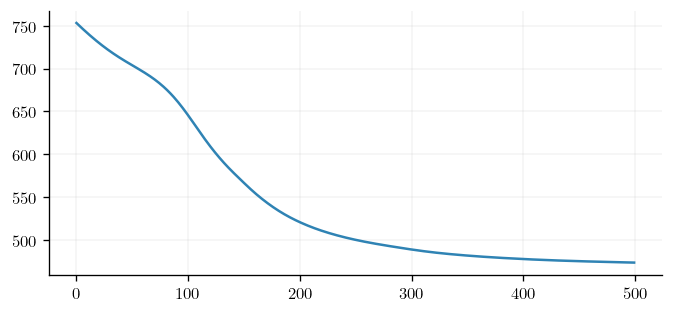

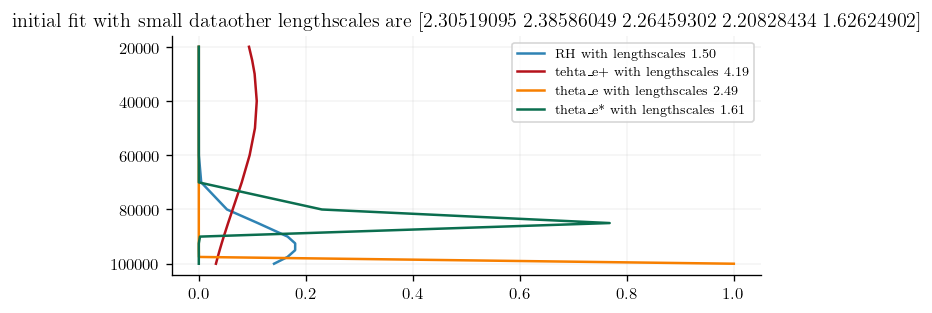

In [17]:
@dataclass
class VerticallyIntegratedKernel(VerticallyIntegratedKernel):
    dummy: Float[Array, " D"] = static_field(pressure_levels)

    
# first fit with small data to get init for SVGP
num_data_for_init= 500
D_small = gpx.Dataset(X = D.X[:num_data_for_init,:],y = D.y[:num_data_for_init,:])
posterior = prior * likelihood
objective = jax.jit(gpx.objectives.ConjugateMLL(negative=True))
#objective = jax.jit(gpx.objectives.NonConjugateMLL(negative=True))
opt_posterior, history = gpx.fit(
    model=posterior,
    objective=objective,
    train_data=D_small,
    optim=ox.adam(learning_rate=1e-2),
    num_iters=500,
    key=jr.PRNGKey(42),
)
plt.plot(history)
plot_params(opt_posterior, title="initial fit with small data")



# # choose inducing inputs and init SVGP
# num_inducing = 100
# #z = jr.normal(key, (num_inducing , D.X.shape[-1])) # todo enable this
# z = D.X[:num_inducing,:]


# init_posterior_at_inducing = opt_posterior.predict(z, D_small)
# # todo try whitening ?
# q = gpx.variational_families.VariationalGaussian(
#     posterior=opt_posterior, 
#     inducing_inputs=z,
#     variational_mean= init_posterior_at_inducing.mean()[:,None],
#     variational_root_covariance= jnp.linalg.cholesky(init_posterior_at_inducing.covariance()), # todo check this is right!
# )
# q = q.replace_trainable(inducing_inputs=False)
# q = q.replace_trainable(variational_mean=False)
# q = q.replace_trainable(variational_root_covariance=False)

# objective = jax.jit(gpx.objectives.ELBO(negative=True))

# optim=ox.adam(1e-1)

# opt_q, history = gpx.fit(
#     model=q,
#     objective=objective,
#     train_data=D,
#     optim=optim,
#     num_iters=100,
#     key=jr.PRNGKey(42),
#     batch_size=128,
# )


# plt.figure()
# plt.plot(history)
# plot_params(opt_q, title="full fit")


In [8]:
# def map_nested_fn(fn):
#   '''Recursively apply `fn` to the key-value pairs of a nested dict'''
#   def map_fn(nested_dict):
#     if not isinstance(nested_dict,dict):
#       nested_dict = nested_dict.__dict__
#     return {k: (map_fn(v) if isinstance(v, dict) else fn(k, v))
#             for k, v in nested_dict.items()}
#   return map_fn
# label_fn = map_nested_fn(lambda k, _: k)


# optim = ox.chain(
#     ox.multi_transform(
#       {
#         "posterior": ox.adam(1e-1), 
#         "variational_mean": zero_grads(), 
#         "variational_root_covariance": zero_grads(),
#         "jitter": zero_grads(), 
#         "pytree_node": zero_grads(), 
#         "trainable": zero_grads(), 
#         "inducing_inputs": zero_grads(),
#         "bijector": zero_grads(),
#         },label_fn), # opt kernel params
#     #ox.multi_transform({"posterior": zero_grads(), "variational_mean": ox.adam(1e-1), "variational_root_covariance": ox.adam(1e-1)},label_fn), # opt variational params
#     )

# optim.init(q)

In [9]:
# def map_nested_fn(fn):
#   '''Recursively apply `fn` to the key-value pairs of a nested dict'''
#   def map_fn(nested_dict):
#     if not isinstance(nested_dict,dict):
#       nested_dict = nested_dict.__dict__
#     return {k: (fn(k, v))
#             for k, v in nested_dict.items()}
#   return map_fn

# label_fn = map_nested_fn(lambda k, _: k)

# label_fn(q)